In [3]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import numpy as np
import json
import requests
import asdf
import regions
from astropy import log
from astropy.io import ascii, fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.nddata import Cutout2D
import astropy.units as u
import stdatamodels


# do this before importing webb
os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/brick/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

from jwst.pipeline import calwebb_image3
from jwst.pipeline import Detector1Pipeline, Image2Pipeline

# Individual steps that make up calwebb_image3
from jwst.tweakreg import TweakRegStep
from jwst.tweakreg.utils import adjust_wcs
from jwst.skymatch import SkyMatchStep
from jwst.outlier_detection import OutlierDetectionStep
from jwst.resample import ResampleStep
from jwst.source_catalog import SourceCatalogStep
from jwst import datamodels
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.datamodels import DataModel
from jwst.datamodels import ImageModel

import jwst.datamodels

In [4]:
filtername = "F212N"

In [3]:
files = glob(f"/orange/adamginsburg/jwst/cloudc/{filtername}/pipeline/*nrc*_cal.fits")
files

['/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00004_nrcb2_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00001_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00004_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_04201_00002_nrca3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00004_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00003_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00001_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00002_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00001_nrcb2_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00004_nrca4_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_04201_

In [4]:
files[8]

'/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00001_nrcb2_cal.fits'

In [6]:
bulky = 0.8*u.arcsec

In [7]:
8*u.arcsec - 0.05*u.arcsec

<Quantity 7.95 arcsec>

In [8]:
-0.3*u.arcsec + bulky + 0.1*u.arcsec

<Quantity 0.6 arcsec>

In [9]:
3.9*u.arcsec - 0.05*u.arcsec

<Quantity 3.85 arcsec>

In [10]:
1.5*u.arcsec + bulky - 0.73*u.arcsec

<Quantity 1.57 arcsec>

In [15]:
filename = files[8]
align_image = filename.replace("_cal.fits", "_align.fits")
shutil.copy(filename, align_image)
offsets_tbl = Table.read('/orange/adamginsburg/jwst/cloudc/offsets/Offsets_JWST_Cloud_C.csv')
row = offsets_tbl[filename.split('/')[-1] == offsets_tbl['Filename_1']]
bulky = 0.8*u.arcsec
print('Running manual align.')
try:
    xshift = float(row['xshift (arcsec)'])*u.arcsec
    yshift = float(row['yshift (arcsec)'])*u.arcsec + bulky
except:
    log.info('Something went wrong with manual align, running default values.')
    visit = filename.split('_')[0][-3:]
    if visit == '001':
        xshift = 8*u.arcsec - 0.05*u.arcsec
        yshift = -0.3*u.arcsec + bulky + 0.1*u.arcsec
    elif visit == '002':
        xshift = 3.9*u.arcsec - 0.05*u.arcsec
        yshift = 1.5*u.arcsec + bulky - 0.73*u.arcsec
    else:
        xshift = 0*u.arcsec
        yshift = 0*u.arcsec
align_fits = ImageModel(align_image)
log.info(f'delta_ra: {yshift} delta_dec: {xshift}')
ww = adjust_wcs(align_fits.meta.wcs, delta_ra = yshift, delta_dec = xshift)
align_fits.meta.wcs = ww
align_fits.save(align_image)
align_fits = fits.open(align_image)
align_fits[1].header.update(ww.to_fits()[0])
align_fits.writeto(align_image, overwrite=True)
filename = align_image

2024-01-08 11:23:37,221 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:23:37,373 - stpipe - INFO - delta_ra: 1.5699999999999998 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.5699999999999998 arcsec delta_dec: 3.85 arcsec [unknown]


In [16]:
im = ImageModel(filename)
fn = filename

In [17]:
im.meta.target

In [18]:
pixel_scale = np.sqrt(fits.getheader(filename, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix
pixel_scale

<Quantity 0.03119615 arcsec / pix>

In [15]:
tbl = Table.read('/orange/adamginsburg/jwst/cloudc/catalogs/crowdsource_based_nircam-f405n_reference_astrometric_catalog.ecsv')
crds = tbl['skycoord']
#np.ma.masked_array(tbl['skycoord'], mask=(tbl['flux'] > np.mean(tbl['flux'])))#tbl['skycoord']


In [20]:
# Load the image and the WCS
im = ImageModel(filename)
hdu = fits.open(filename)#ImageModel(filename)
ww = WCS(hdu['SCI'].header)

reg_frame = regions.RectangleSkyRegion(center=im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2']), width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_frame = crds[reg_frame.contains(crds, wcs=ww)]

2024-01-08 11:23:40,193 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -119.968543 from OBSGEO-[XYZ].
Set OBSGEO-B to   -11.519150 from OBSGEO-[XYZ].
Set OBSGEO-H to 1386516073.994 from OBSGEO-[XYZ]'.
  warnings.warn(



In [21]:
position = crds_frame[np.random.randint(len(crds_frame)-1)]
#im.meta.wcs.pixel_to_world(hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2'])

In [22]:
# <SkyCoord (ICRS): (ra, dec) in deg
#    (266.59537529, -28.54638297)>
position

<SkyCoord (ICRS): (ra, dec) in deg
    (266.60143988, -28.59361375)>

In [23]:
size = (5*u.arcsec/pixel_scale, 5*u.arcsec/pixel_scale)#im.meta.wcs.world_to_pixel(1*u.arcsec, 1*u.arcsec)

# Make the cutout, including the WCS
cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)
reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)
crds_in = crds[reg.contains(crds, wcs=ww)]

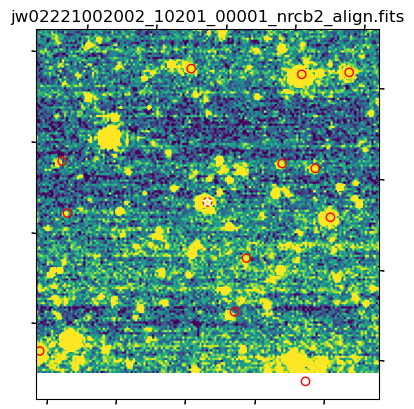

In [24]:
minn = 5
maxx = 90

ax = plt.subplot(111, projection=cutout.wcs)
vmin = np.nanpercentile(cutout.data.flatten(), minn)
vmax = np.nanpercentile(cutout.data.flatten(), maxx)
ax.imshow(np.nan_to_num(cutout.data), vmin=vmin, vmax=vmax)
# files[5] = ra+0.73*u.arcsec dec+0.05*u.arcsec
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
#ax.scatter(crds_in.ra+0.05*u.arcsec, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
ax.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax.get_transform('world'))

#ax0 = ax.coords[0]
#ax0.set_format_unit(u.deg)
#ax1 = ax.coords[1]
#ax1.set_format_unit(u.deg)
ax.set_title(f'{os.path.basename(filename)}')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

In [239]:
files

['/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00004_nrcb2_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00001_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00004_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_04201_00002_nrca3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00004_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00003_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00001_nrcb3_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00002_nrca1_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00001_nrcb2_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00004_nrca4_cal.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_04201_

In [13]:
ls /orange/adamginsburg/jwst/cloudc/F212N/pipeline/*tweakregstep*

/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00001_nrca1_align_tweakregstep.fits
/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00001_nrca2_align_tweakregstep.fits
/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00001_nrca3_align_tweakregstep.fits
/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00001_nrca4_align_tweakregstep.fits
/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00002_nrca1_align_tweakregstep.fits
/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00002_nrca2_align_tweakregstep.fits
/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00002_nrca3_align_tweakregstep.fits
/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00002_nrca4_align_tweakregstep.fits
/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00003_nrca1_align_tweakregstep.fits
/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04

In [ ]:
size = (2048*u.pix*pixel_scale, 2048*u.pix*pixel_scale)

# Image 1
fn1 = '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00001_nrcb1_align.fits'
im1 = ImageModel(fn1)
hdu1 = fits.open(fn1)
ww1 = WCS(hdu1['SCI'].header)

pixel_scale = np.sqrt(fits.getheader(fn1, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix
cntr1 = im1.meta.wcs.pixel_to_world(hdu1['SCI'].header['CRPIX1'], hdu1['SCI'].header['CRPIX2'])

cutout1 = Cutout2D(hdu1['SCI'].data, position=cntr1, size=size, wcs=ww1)

ax1 = plt.subplot(221, projection=cutout1.wcs)
vmin = np.nanpercentile(cutout1.data.flatten(), minn)
vmax = np.nanpercentile(cutout1.data.flatten(), maxx)
plt.imshow(np.nan_to_num(cutout1.data), vmin=vmin, vmax=vmax)
ax1_0 = ax1.coords[0]
ax1_0.set_format_unit(u.arcsec)
ax1_1 = ax1.coords[1]
ax1_1.set_format_unit(u.arcsec)
ax1.set_title(f'{os.path.basename(fn1)}')
ax1.set_xlabel('RA')
ax1.set_ylabel('Dec')

# Image 2
fn2 = '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00002_nrcb1_align.fits'
im2 = ImageModel(fn2)
hdu2 = fits.open(fn2)
ww2 = WCS(hdu1['SCI'].header)

pixel_scale = np.sqrt(fits.getheader(fn2, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix
cntr2 = im2.meta.wcs.pixel_to_world(hdu2['SCI'].header['CRPIX1'], hdu2['SCI'].header['CRPIX2'])

cutout2 = Cutout2D(hdu2['SCI'].data, position=cntr2, size=size, wcs=ww2)

ax2 = plt.subplot(222, projection=cutout2.wcs)
vmin = np.nanpercentile(cutout2.data.flatten(), minn)
vmax = np.nanpercentile(cutout2.data.flatten(), maxx)
plt.imshow(np.nan_to_num(cutout2.data), vmin=vmin, vmax=vmax)
ax2_0 = ax2.coords[0]
ax2_0.set_format_unit(u.arcsec)
ax2_1 = ax2.coords[1]
ax2_1.set_format_unit(u.arcsec)
ax2.set_title(f'{os.path.basename(fn2)}')
ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')

# Image 3
fn3 = '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00003_nrcb1_align.fits'
im3 = ImageModel(fn3)
hdu3 = fits.open(fn3)
ww3 = WCS(hdu3['SCI'].header)

pixel_scale = np.sqrt(fits.getheader(fn3, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix
cntr3 = im3.meta.wcs.pixel_to_world(hdu3['SCI'].header['CRPIX1'], hdu3['SCI'].header['CRPIX2'])

cutout3 = Cutout2D(hdu3['SCI'].data, position=cntr3, size=size, wcs=ww3)

ax3 = plt.subplot(223, projection=cutout3.wcs)
vmin = np.nanpercentile(cutout3.data.flatten(), minn)
vmax = np.nanpercentile(cutout3.data.flatten(), maxx)
plt.imshow(np.nan_to_num(cutout3.data), vmin=vmin, vmax=vmax)
ax3_0 = ax3.coords[0]
ax3_0.set_format_unit(u.arcsec)
ax3_1 = ax3.coords[1]
ax3_1.set_format_unit(u.arcsec)
ax3.set_title(f'{os.path.basename(fn3)}')
ax3.set_xlabel('RA')
ax3.set_ylabel('Dec')

# Image 4
fn4 = '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00004_nrcb1_align.fits'
im4 = ImageModel(fn4)
hdu4 = fits.open(fn4)
ww4 = WCS(hdu4['SCI'].header)

pixel_scale = np.sqrt(fits.getheader(fn4, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix
cntr4 = im4.meta.wcs.pixel_to_world(hdu4['SCI'].header['CRPIX1'], hdu4['SCI'].header['CRPIX2'])

cutout4 = Cutout2D(hdu4['SCI'].data, position=cntr4, size=size, wcs=ww4)

ax4 = plt.subplot(224, projection=cutout4.wcs)
vmin = np.nanpercentile(cutout4.data.flatten(), minn)
vmax = np.nanpercentile(cutout4.data.flatten(), maxx)
plt.imshow(np.nan_to_num(cutout4.data), vmin=vmin, vmax=vmax)
ax4_0 = ax4.coords[0]
ax4_0.set_format_unit(u.arcsec)
ax4_1 = ax4.coords[1]
ax4_1.set_format_unit(u.arcsec)
ax4.set_title(f'{os.path.basename(fn4)}')
ax4.set_xlabel('RA')
ax4.set_ylabel('Dec')

plt.tight_layout()

2024-01-08 11:53:36,895 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.363789 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'.
  warnings.warn(

2024-01-08 11:53:37,681 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.360256 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.188718 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298897710.101 from OBSGEO-[XYZ]'.
  warnings.warn(

2024-01-08 11:53:38,319 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.357902 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.190008 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298908065.983 from OBSGEO-[XYZ]'.
  warnings.warn(

2024-01-08 11:53:39,008 - st

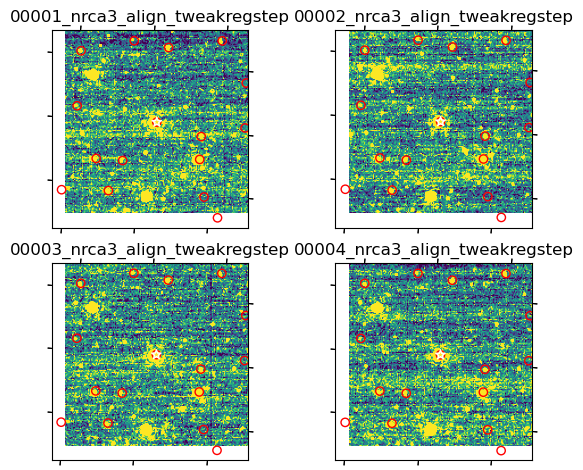

In [27]:
nrc = 'nrca3'
ra_shift = 0.0*u.arcsec
dec_shift = 0.0*u.arcsec
minn = 5
maxx = 90

# Image 1
fn1 = f'/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00001_{nrc}_align_tweakregstep.fits'
im1 = ImageModel(fn1)
hdu1 = fits.open(fn1)
ww1 = WCS(hdu1['SCI'].header)
pixel_scale = np.sqrt(fits.getheader(fn1, ext=1)['PIXAR_A2']*u.arcsec**2)/u.pix

reg_frame = regions.RectangleSkyRegion(center=im1.meta.wcs.pixel_to_world(hdu1['SCI'].header['CRPIX1'], hdu1['SCI'].header['CRPIX2']), width=2048*u.pix*pixel_scale, height=2048*u.pix*pixel_scale)
crds_frame = crds[reg_frame.contains(crds, wcs=ww1)]
position = crds_frame[np.random.randint(len(crds_frame)-1)]
size = (5*u.arcsec/pixel_scale, 5*u.arcsec/pixel_scale)
#(2048*u.pix*pixel_scale, 2048*u.pix*pixel_scale)
reg = regions.RectangleSkyRegion(center=position, width=size[1]*pixel_scale, height=size[0]*pixel_scale)

crds_in = crds[reg.contains(crds, wcs=ww1)]

cntr1 = im1.meta.wcs.pixel_to_world(hdu1['SCI'].header['CRPIX1'], hdu1['SCI'].header['CRPIX2'])

cutout1 = Cutout2D(hdu1['SCI'].data, position=position, size=size, wcs=ww1)

ax1 = plt.subplot(221, projection=cutout1.wcs)
vmin = np.nanpercentile(cutout1.data.flatten(), minn)
vmax = np.nanpercentile(cutout1.data.flatten(), maxx)
plt.imshow(np.nan_to_num(cutout1.data), vmin=vmin, vmax=vmax)
ax1.scatter(crds_in.ra+ra_shift, crds_in.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax1.get_transform('world'))
ax1.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax1.get_transform('world'))
ax1_0 = ax1.coords[0]
ax1_0.set_format_unit(u.arcsec)
ax1_1 = ax1.coords[1]
ax1_1.set_format_unit(u.arcsec)
ax1.set_title(f'{os.path.basename(fn1)[20:-5]}')
ax1.set_yticklabels([])
ax1.set_xticklabels([])

# Image 2
fn2 = fn1.replace('_00001_', '_00002_')
#'/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00002_nrcb1_align.fits'
im2 = ImageModel(fn2)
hdu2 = fits.open(fn2)
ww2 = WCS(hdu2['SCI'].header)

crds_in = crds[reg.contains(crds, wcs=ww2)]

cntr2 = im2.meta.wcs.pixel_to_world(hdu2['SCI'].header['CRPIX1'], hdu2['SCI'].header['CRPIX2'])

cutout2 = Cutout2D(hdu2['SCI'].data, position=position, size=size, wcs=ww2)

ax2 = plt.subplot(222, projection=cutout2.wcs, sharex=ax1, sharey=ax1)
vmin = np.nanpercentile(cutout2.data.flatten(), minn)
vmax = np.nanpercentile(cutout2.data.flatten(), maxx)
plt.imshow(np.nan_to_num(cutout2.data), vmin=vmin, vmax=vmax)
ax2.scatter(crds_in.ra+ra_shift, crds_in.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax2.get_transform('world'))
ax2.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax2.get_transform('world'))
ax2_0 = ax2.coords[0]
ax2_0.set_format_unit(u.arcsec)
ax2_1 = ax2.coords[1]
ax2_1.set_format_unit(u.arcsec)
ax2.set_title(f'{os.path.basename(fn2)[20:-5]}')
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Image 3
fn3 = fn1.replace('_00001_', '_00003_')
#'/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00003_nrcb1_align.fits'
im3 = ImageModel(fn3)
hdu3 = fits.open(fn3)
ww3 = WCS(hdu3['SCI'].header)

crds_in = crds[reg.contains(crds, wcs=ww3)]

cntr3 = im3.meta.wcs.pixel_to_world(hdu3['SCI'].header['CRPIX1'], hdu3['SCI'].header['CRPIX2'])

cutout3 = Cutout2D(hdu3['SCI'].data, position=position, size=size, wcs=ww3)

ax3 = plt.subplot(223, projection=cutout3.wcs, sharex=ax1, sharey=ax1)
vmin = np.nanpercentile(cutout3.data.flatten(), minn)
vmax = np.nanpercentile(cutout3.data.flatten(), maxx)
plt.imshow(np.nan_to_num(cutout3.data), vmin=vmin, vmax=vmax)
ax3.scatter(crds_in.ra+ra_shift, crds_in.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax3.get_transform('world'))
ax3.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax3.get_transform('world'))
ax3_0 = ax3.coords[0]
ax3_0.set_format_unit(u.arcsec)
ax3_1 = ax3.coords[1]
ax3_1.set_format_unit(u.arcsec)
ax3.set_title(f'{os.path.basename(fn3)[20:-5]}')
ax3.set_yticklabels([])
ax3.set_xticklabels([])

# Image 4
fn4 = fn1.replace('_00001_', '_00004_')
#'/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00004_nrcb1_align.fits'
im4 = ImageModel(fn4)
hdu4 = fits.open(fn4)
ww4 = WCS(hdu4['SCI'].header)

crds_in = crds[reg.contains(crds, wcs=ww4)]

cntr4 = im4.meta.wcs.pixel_to_world(hdu4['SCI'].header['CRPIX1'], hdu4['SCI'].header['CRPIX2'])

cutout4 = Cutout2D(hdu4['SCI'].data, position=position, size=size, wcs=ww4)

ax4 = plt.subplot(224, projection=cutout4.wcs, sharex=ax1, sharey=ax1)
vmin = np.nanpercentile(cutout4.data.flatten(), minn)
vmax = np.nanpercentile(cutout4.data.flatten(), maxx)
plt.imshow(np.nan_to_num(cutout4.data), vmin=vmin, vmax=vmax)
ax4.scatter(crds_in.ra+ra_shift, crds_in.dec+dec_shift, edgecolor='r', facecolor='none', transform=ax4.get_transform('world'))
ax4.scatter(position.ra, position.dec, edgecolor='white', facecolor='none', s=50, marker='*', transform=ax4.get_transform('world'))
ax4_0 = ax4.coords[0]
ax4_0.set_format_unit(u.arcsec)
ax4_1 = ax4.coords[1]
ax4_1.set_format_unit(u.arcsec)
ax4.set_title(f'{os.path.basename(fn4)[20:-5]}')
ax4.set_yticklabels([])
ax4.set_xticklabels([])

plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [138]:
'''
for f in files:
    align_image = member['expname'].replace("_destreak.fits", "_align.fits")
    shutil.copy(member['expname'], align_image)
    offsets_tbl = Table.read('/orange/adamginsburg/jwst/cloudc/offsets/Offsets_JWST_Cloud_C.csv')
    row = offsets_tbl[member['expname'].split('/')[-1] == offsets_tbl['Filename_1']]
    print('Running manual align.')
    try:
        xshift = float(row['xshift (arcsec)'])*u.arcsec
        yshift = float(row['yshift (arcsec)'])*u.arcsec
    except:
        log.info('Something went wrong with manual align, running default values.')
        visit = member['expname'].split('_')[0][-3:]
        if visit == '001':
            xshift = 8*u.arcsec
            yshift = -0.3*u.arcsec
        elif visit == '002':
            xshift = 3.9*u.arcsec
            yshift = 1*u.arcsec
        else:
            xshift = 0*u.arcsec
            yshift = 0*u.arcsec
    align_fits = ImageModel(align_image)
    ww = adjust_wcs(align_fits.meta.wcs, delta_ra = yshift, delta_dec = xshift)
    align_fits.meta.wcs = ww
    align_fits.save(align_image)
    align_fits = fits.open(align_image)
    align_fits[1].header.update(ww.to_fits()[0])
    align_fits.writeto(align_image, overwrite=True)
'''

'\nfor f in files:\n    align_image = member[\'expname\'].replace("_destreak.fits", "_align.fits")\n    shutil.copy(member[\'expname\'], align_image)\n    offsets_tbl = Table.read(\'/orange/adamginsburg/jwst/cloudc/offsets/Offsets_JWST_Cloud_C.csv\')\n    row = offsets_tbl[member[\'expname\'].split(\'/\')[-1] == offsets_tbl[\'Filename_1\']]\n    print(\'Running manual align.\')\n    try:\n        xshift = float(row[\'xshift (arcsec)\'])*u.arcsec\n        yshift = float(row[\'yshift (arcsec)\'])*u.arcsec\n    except:\n        log.info(\'Something went wrong with manual align, running default values.\')\n        visit = member[\'expname\'].split(\'_\')[0][-3:]\n        if visit == \'001\':\n            xshift = 8*u.arcsec\n            yshift = -0.3*u.arcsec\n        elif visit == \'002\':\n            xshift = 3.9*u.arcsec\n            yshift = 1*u.arcsec\n        else:\n            xshift = 0*u.arcsec\n            yshift = 0*u.arcsec\n    align_fits = ImageModel(align_image)\n    ww = a

In [26]:
for f in files:
    filename = f
    align_image = filename.replace("_cal.fits", "_align.fits")
    shutil.copy(filename, align_image)
    offsets_tbl = Table.read('/orange/adamginsburg/jwst/cloudc/offsets/Offsets_JWST_Cloud_C.csv')
    row = offsets_tbl[filename.split('/')[-1] == offsets_tbl['Filename_1']]
    #bulky = 0.8*u.arcsec
    print('Running manual align.')
    try:
        xshift = float(row['xshift (arcsec)'])*u.arcsec
        yshift = float(row['yshift (arcsec)'])*u.arcsec + bulky
    except:
        log.info('Something went wrong with manual align, running default values.')
        visit = filename.split('_')[0][-3:]
        if visit == '001':
            xshift = 7.95*u.arcsec
            yshift = 0.6*u.arcsec
        elif visit == '002':
            xshift = 3.85*u.arcsec
            yshift = 1.57*u.arcsec
        else:
            xshift = 0*u.arcsec
            yshift = 0*u.arcsec
    align_fits = ImageModel(align_image)
    log.info(f'delta_ra: {yshift} delta_dec: {xshift}')
    ww = adjust_wcs(align_fits.meta.wcs, delta_ra = yshift, delta_dec = xshift)
    align_fits.meta.wcs = ww
    align_fits.save(align_image)
    align_fits = fits.open(align_image)
    align_fits[1].header.update(ww.to_fits()[0])
    align_fits.writeto(align_image, overwrite=True)
    #filename = align_image

2024-01-08 11:24:47,344 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]


2024-01-08 11:24:47,653 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:24:48,708 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:24:48,877 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:24:49,880 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:24:50,047 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:24:51,070 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:24:51,236 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:24:52,379 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:24:52,572 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:24:53,616 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:24:53,786 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:24:54,736 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:24:54,907 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:24:56,308 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:24:56,480 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:24:57,143 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:24:57,304 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:24:58,238 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]


2024-01-08 11:24:58,573 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:24:59,453 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:24:59,624 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:00,410 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:00,580 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:01,550 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:01,716 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:02,800 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:02,986 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:03,839 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]


2024-01-08 11:25:04,171 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:04,978 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:05,144 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:05,890 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:06,051 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:07,145 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:07,310 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:08,336 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:08,498 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:09,501 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:09,662 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:10,623 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:10,788 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:11,724 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:11,889 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:12,800 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:12,966 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:14,038 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:14,203 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:15,206 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:15,372 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:16,117 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]


2024-01-08 11:25:16,457 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:17,456 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:17,624 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:18,476 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:18,645 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:19,542 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:19,703 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:20,595 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:20,759 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:21,604 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]


2024-01-08 11:25:21,949 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:22,928 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:23,089 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:24,121 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:24,288 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:25,306 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:25,470 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:26,431 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:26,607 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:27,587 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:27,757 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:28,886 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:29,054 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:29,950 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:30,119 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:31,051 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:31,219 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:32,367 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:32,532 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:33,429 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:33,594 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:34,404 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]


2024-01-08 11:25:34,766 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:35,607 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:35,773 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:36,574 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:36,738 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:37,599 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:37,759 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:38,574 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:38,737 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:39,554 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:39,712 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:40,849 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:41,002 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:42,106 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:42,271 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:43,195 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:43,352 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:44,392 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:44,546 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:45,390 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:45,553 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:46,988 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:47,157 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:48,107 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:48,271 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:49,276 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:49,440 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:50,263 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:50,456 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:51,319 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]


2024-01-08 11:25:51,542 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:52,615 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:52,781 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:25:53,726 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:53,902 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:54,892 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:55,065 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:55,996 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:56,162 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:56,979 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:57,171 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:58,115 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]


2024-01-08 11:25:58,476 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:25:59,487 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:25:59,679 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:00,578 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:00,768 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:01,914 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:02,104 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:03,335 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:03,533 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec
2024-01-08 11:26:04,562 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:04,751 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:05,677 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:05,840 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:07,134 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:07,297 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:08,501 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:08,663 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:09,825 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:09,987 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:10,899 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:11,056 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:12,186 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:12,346 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:13,235 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:13,425 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:14,801 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:14,965 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:15,851 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:16,014 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:16,868 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:17,056 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:18,166 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:18,333 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:19,203 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:19,371 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:20,224 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:20,413 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:21,411 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:21,600 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:22,496 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]


2024-01-08 11:26:22,717 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:23,636 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:23,819 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:24,877 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:25,047 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:25,882 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:26,072 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:27,280 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:27,466 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:28,329 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:28,518 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:29,560 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:29,727 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:34,327 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:34,504 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:35,355 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:35,521 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:36,451 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:36,615 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:37,671 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:37,843 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:38,712 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:38,899 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:39,788 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:39,956 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:41,139 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:41,305 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:42,449 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:42,641 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:43,838 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:44,009 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:45,012 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:45,196 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:46,179 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]


2024-01-08 11:26:46,401 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:47,547 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:47,715 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:48,520 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:48,691 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:49,685 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:49,870 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:50,821 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:51,014 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:52,362 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:52,536 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:53,638 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:53,808 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:54,862 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:55,052 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:56,134 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:56,321 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:26:57,282 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:57,457 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:26:58,437 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:26:58,625 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:00,312 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:00,504 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:01,688 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:01,860 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:02,972 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:03,140 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:04,265 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:04,439 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:27:05,301 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:05,486 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:06,604 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:06,782 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:27:07,683 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:07,853 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:27:08,903 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:09,098 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec
2024-01-08 11:27:09,876 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:10,068 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:10,978 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:11,169 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:12,123 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:12,295 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:13,342 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:13,541 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec
2024-01-08 11:27:14,770 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:14,948 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:15,981 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:16,159 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:27:16,915 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:17,085 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:27:17,860 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:18,048 - stpipe - INFO - delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 1.57 arcsec delta_dec: 3.85 arcsec [unknown]


2024-01-08 11:27:18,975 - stpipe - INFO - Something went wrong with manual align, running default values.


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


2024-01-08 11:27:19,171 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec
2024-01-08 11:27:20,359 - stpipe - INFO - Something went wrong with manual align, running default values.
2024-01-08 11:27:20,532 - stpipe - INFO - delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec


Running manual align.
INFO: Something went wrong with manual align, running default values. [unknown]
INFO: delta_ra: 0.6 arcsec delta_dec: 7.95 arcsec [unknown]


In [1]:
print('done')

done


In [192]:
glob(f"/orange/adamginsburg/jwst/cloudc/{filtername}/pipeline/*nrca*_align.fits")

['/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00003_nrca1_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00002_nrca2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00004_nrca2_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00004_nrca1_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_04201_00004_nrca3_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_04201_00001_nrca4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00001_nrca1_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_04201_00002_nrca3_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002002_10201_00004_nrca4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/jw02221002001_10201_00001_nrca4_align.fits',
 '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/

In [5]:
models = jwst.datamodels.open(glob(f"/orange/adamginsburg/jwst/cloudc/{filtername}/pipeline/*nrca*_align.fits"))

In [6]:
abs_refcat = '/orange/adamginsburg/jwst/cloudc/catalogs/crowdsource_based_nircam-f405n_reference_astrometric_catalog_truncated10000.ecsv'
#abs_refcat = '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221-o002_t001_nircam_clear-F405N-merged_vvvcat.fits'

In [7]:
tweakreg = TweakRegStep()
tweakreg.fitgeometry = 'general'
tweakreg.kernel_fwhm = 2.341
tweakreg.brightest = 500
tweakreg.snr_threshold = 30
tweakreg.abs_refcat = abs_refcat
tweakreg.save_catalogs = True
tweakreg.catalog_format = 'ecsv'
#tweakreg.kernel_fwhm = fwhm_pix
tweakreg.nclip = 5
tweakreg.sharplo = 0.3
tweakreg.sharphi = 0.9
tweakreg.roundlo = -0.25
tweakreg.roundhi = 0.25
tweakreg.separation = 0.5
tweakreg.tolerance = 0.7
tweakreg.sigma = 3.0
tweakreg.output_dir = f"/orange/adamginsburg/jwst/cloudc/{filtername}/pipeline/"#output_dir
tweakreg.save_results = True
tweakreg.skip = False
tweakreg.searchrad = 0.5
tweakreg.abs_searchrad = 0.4

tweak = tweakreg.run(models)


2024-01-08 11:31:17,218 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-01-08 11:31:17,426 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args (<ModelContainer>,).
2024-01-08 11:31:17,429 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/orange/adamginsburg/jwst/cloudc/F212N/pipeline/', 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': True, 'use_custom_catalogs': False, 'catalog_format': 'ecsv', 'catfile': '', 'kernel_fwhm': 2.341, 'snr_threshold': 30, 'sharplo': 0.3, 'sharphi': 0.9, 'roundlo': -0.25, 'roundhi': 0.25, 'brightest': 500, 'peakmax': None, 'bkg_boxsize': 400, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 15, 'searchrad': 0.5, 'use2dhist': True, 'separation': 0.5, 'tolerance': 0.7, 'xoffset': 0.0, '

In [8]:
print('done')

done


In [9]:
st = 'jw02221002002_08201_00003_nrcblong_cal.fits'
st

'jw02221002002_08201_00003_nrcblong_cal.fits'

In [10]:
st.replace('_cal.fits', '_test.fits')

'jw02221002002_08201_00003_nrcblong_cal.fits'